# Hidden Markov Models

In this homework assignment you will train and evaluate a toy speech recognizer that can recognize 'yes' and 'no'.  As we move into the latter half of the course, note that the assignments will have less and less hand holding.  The goal is for you to become more and more independent, so that you are ready to work independently on the final project.  This assignment should be done in pairs and only one submission needs to be submitted on Gradescope for each team.  In your submission, you should create a single .zip file that contains your jupyter notebook, audio data, annotation data, and generated prediction files.

Please indicate the team member names here: ________________________

How many hours you each spent on this assignment: _________ (partner 1), __________ (partner 2)

This assignment will be broken down into 5 main sections:
1. Collect data & annotate (10 points)
2. Train model using manual annotations (20 points)
3. Perform inference on test data (20 points)
4. Infer strong labels on weakly labeled data (20 points)
5. Retrain model and evaluate on test data (20 points)

An additional 10 points will be based on how well organized, commented, and readable your code is.

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
from pathlib import Path
from scipy.stats import multivariate_normal

### Part 1: Data Collection & Annotation

For the data collection, you will record 10 audio clips:
- Training data: 5 recordings.  Five of the audio recordings will be for training.  For these recordings, you should say a random sequence of ten yes's or no's.  For example, one recording might be 'yes no yes yes no no yes yes yes no'.  The recordings do not all have to have the same sequence of yes's and no's.  When recording your speaking, please include a variable-length silence in between each word.
- Test data: 5 recordings.  Five of the audio recordings will be for testing.  For these recordings, you should say a variable-length sequence of yes's and no's.  For example, one recording might be 'yes no' and another might be 'no yes yes no no yes no yes'.  Use a variety of different lengths in your sentences.  Again, please include silence in between each word.

All audio recordings should be done by a single person on a single device in the same environment (e.g. recorded on a cell phone in your dorm room).

Once you have recorded the audio, convert them to a format that librosa can read (e.g. wav or mp3) and put them in a folder entitled 'audio/'.  Name the files train1.mp3, train2.mp3, test1.mp3, test2.mp3, etc.

In [4]:
AUDIO_DIR = Path('hw7audio') 
ext = '.mp3' # audio format

In [5]:
def verifyAudioData(indir, file_ext):
    # verifies that all the needed audio files are present

    # check train files
    for i in range(5):
        curfile = Path(AUDIO_DIR, f'train{i+1}').with_suffix(ext)
        assert curfile.is_file(), f'Missing training file {curfile}'

    # check test files
    for i in range(5):
        curfile = Path(AUDIO_DIR, f'test{i+1}').with_suffix(ext)
        assert curfile.is_file(), f'Missing test file {curfile}'

    print('All required audio data files are present!')
    
    return

In [7]:
verifyAudioData(AUDIO_DIR, ext)

All required audio data files are present!


Next you will create two different kinds of annotations: weak labels and strong labels.  

**Weak labels**.  Create two annotation files for the weak labels.  The file train.transcription should look like:

train1.mp3|yes no yes no no yes no yes no yes\
train2.mp3|no yes no yes no yes no no yes yes\ 
train3.mp3|yes no yes yes yes yes no yes no yes\
train4.mp3|no no yes no yes no no yes no no\
train5.mp3|yes no yes yes no no no yes no yes\

The file test.transcription should look like:

test1.mp3|yes no\
test2.mp3|yes no no yes\
test3.mp3|yes no yes no yes\
test4.mp3|no yes no yes yes no\
test5.mp3|yes no yes no no yes no yes yes yes no\

**Strong labels**.  Create one annotation file for train1.mp3 (only) containing strong labels.  The file train1.labels should be in the following format:

0.00 1.37 sil\
1.37 2.60 yes\
2.60 5.20 sil\
5.20 6.30 no\
6.30 8.10 sil\
...\
12.30 13.25 yes\
13.25 15.90 sil

For annotating timestamps, I recommend that you use Audacity.  Note that we are only annotating one file with strong labels because this process is time-consuming!

In [8]:
ANNOT_DIR = Path('ext')
train_transcripts = Path(ANNOT_DIR, 'train.transcription')
test_transcripts = Path(ANNOT_DIR, 'test.transcription')
train1_labels = Path(ANNOT_DIR, 'train1.labels')

In [9]:
def verifyAnnotations():
    # verifies that all of the needed annotation files are present

    assert train_transcripts.is_file(), f'Missing transcription file {train_transcripts}'    
    assert test_transcripts.is_file(), f'Missing transcription file {test_transcripts}'    
    assert train1_labels.is_file(), f'Missing label file {train1_labels}'
    print('All required annotation files are present!')
    
    return

In [10]:
verifyAnnotations()

All required annotation files are present!


Using the above format for your label file, you should be able to visualize your labels alongside the audio in Audacity by selecting File --> Import --> Labels.  An example is shown below.  This type of visualization will be useful in evaluating how accurate your alignments and predictions are.

![Snapshot](labels_snapshot.png)

**Graded**: Please include a similar visualization of your data below.  Make sure you include your image file in your submission!

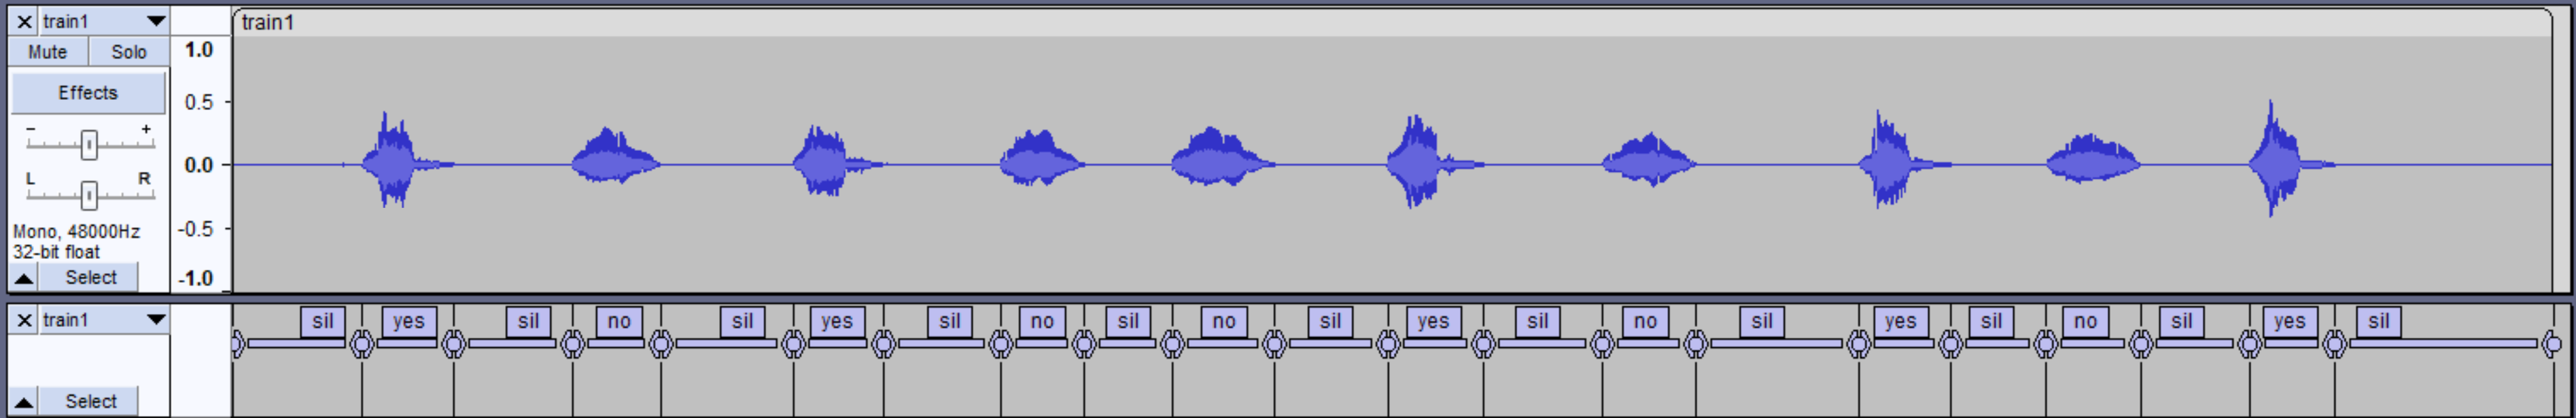

### Part 2: Model Training

In this part, you will train an HMM model based (only) on the label file for train1.mp3.  You must complete the implementations of the functions below.  No unit tests will be provided, though, so make sure to check your own work and verify that they are what you expect!

The function below extracts a feature called mel frequency cepstral coefficients.  Unlike chroma features, which focus on pitch (i.e. fine spectral structure), MFCCs focus on timbre (i.e. rough spectral structure) and are helpful for recognizing speech or distinguishing between different instruments.  You may use the librosa function [librosa.feature.mfcc](https://librosa.org/doc/latest/generated/librosa.feature.mfcc.html) with default arguments.

In [16]:
def computeFeatures(audiofile):
    """
    This function extracts mel frequency cepstral coefficients (MFCCs) from a given audio file.
        
    Inputs
        - audiofile: filepath to the audio recording that you want to extract MFCC features from
        
    Outputs
        - O: an F x N array containing MFCC features, where F corresponds to different features and 
             N corresponds to different audio frames
        - hop: the hop size (in seconds) between adjacent frames
    """
    ### INSERT CODE BELOW ###
    # Load the audio file
    y, sr = lb.load(audiofile)
    
    # Extract MFCC features
    O = lb.feature.mfcc(y=y, sr=sr)
    
    # Calculate hop size
    hop = lb.get_duration(y=y, sr=sr) / O.shape[1]

    return O, hop

The function below constructs a mapping between the states and their numeric identifiers.  For ease of grading, please use the following mapping:
- sil -> 0
- Y -> 1
- EH -> 2
- S -> 3
- N -> 4
- OH -> 5

In [17]:
def getStateMapping():
    """
    Returns a mapping between the string and numeric representations of the six different states.
    
    Outputs
      - states: a list that contains the states (in order).  This allows you to map from the numeric identifier
        to the string representation (e.g. states[3])
      - stateStr2id: a dict that maps from the state string representation to its numeric identifier (e.g. stateStr2id['EH'])
    """
    states = ['sil', 'Y', 'EH', 'S', 'N', 'OH']
    stateStr2id = {state: i for i, state in enumerate(states)}
    
    return states, stateStr2id

The function below converts a .labels file into a sequence of states per frame.  You may assume that states in a word have equal duration (e.g. if the word 'yes' lasts 1.2 seconds, you can assume that 'Y', 'EH', and 'S' each have duration 0.4 sec).

In [97]:
#Helper function
def word2syl(word, word_frames, str2id):
    """
    Outputs
      - S: list containing the sequence of numeric states for each audio frame
    """
    S = []
    if word=='yes':
        partition = int(word_frames/3)     
        S.extend([str2id['Y'] for _ in range(partition)])
        S.extend([str2id['EH'] for _ in range(partition)])
        S.extend([str2id['S'] for _ in range(word_frames-2*partition)])

    elif word=='no':
        partition = int(word_frames/2)
        S.extend([str2id['N'] for _ in range(partition)])
        S.extend([str2id['OH'] for _ in range(word_frames-partition)])

    else:
        partition = int(word_frames/2)
        S.extend([str2id['sil'] for _ in range(word_frames)])
    return S

In [108]:
def getStatesFromLabelFile(labelfile, hopsize, str2id):
    """
    Reads in a label file and returns a sequence of states for each audio frame.  For any given word, it assumes
    that the constituent states all have equal duration.  For example, if the word 'yes' lasts 1.2 seconds, the constituent
    states 'Y', 'EH', and 'S' are assumed to each have duration 0.4 seconds.
    
    Inputs
      - labelfile: filepath to the .labels or .forcealign file 
      - hopsize: the hop size in seconds between adjacent audio frames
      - str2id: dict that maps from the state's string representation to its numeric representation

    Outputs
      - S: list containing the sequence of numeric states for each audio frame
    """
    # Read the label file
    with open(labelfile, 'r') as file:
        lines = file.readlines()
    
    # Initialize variables
    S = []
    frames = 0
    
    # Parse label file
    for line in lines:
        # Split line into word and duration
        parts = line.strip().split()

        # Extract word and duration
        word = parts[2]
        dur = float(parts[1])-float(parts[0])
        word_frames = int(dur / hopsize)
        frames+= word_frames
        # Add corresponding sequence of numeric states for audio frames for each word
        S.extend(word2syl(word, word_frames, str2id))
    print(len(S) == frames)
    return S

This is a good place to verify that your functions are producing correct outputs:

In [109]:
O, hop = computeFeatures(Path(AUDIO_DIR, 'train1.mp3'))
states, stateStr2id = getStateMapping()
S = getStatesFromLabelFile(train1_labels, hop, stateStr2id)
print(S)

True
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

The function below trains an HMM given a list of observations (i.e. MFCC feature matrices) and corresponding states.  A few helpful tips:
- In this part of the assignment, you will only train the model on the train1.mp3 example, but your function below should be able to handle multiple training examples so that you can reuse this function in part 5.
- You may assume that recordings always begin in the silent state.
- You should assume that the emission probability model is a multivariate Gaussian model.
- You should decompose this function and define other sub-functions as needed to keep your code neat and organized.

In [ ]:
def trainHMM(O_list, S_list, states):
    """
    Trains an HMM given a list of observations and corresponding states.  The HMM assumes a multivariate Gaussian
    emission probability model.

    Inputs
      - O_list: a list of matrices, where each matrix contains the MFCC coefficients for a single training recording
      - S_list: a list of arrays, where each array specifies the states in each audio frame for a single training recording
      - states: a list specifying the states in their string representation
      
    Outputs
      - A: the state transition probability matrix
      - pi: the distribution of the initial state
      - means: a matrix where each row specifies the mean of the distribution for a single state
      - covars: a 3D tensor where the first index specifies a state, and the remaining two indices specify the covariance 
        matrix for the state's distribution
    """
    ### INSERT CODE BELOW ###
    raise NotImplementedError

    return (A, pi, means, covars)

Use the functions defined above to train an HMM model on the train1.labels file (only).  For grading purposes, please print out the following variables (and make sure your submitted notebook is showing the values): 
- the state transition probability matrix A
- the means for all six states
- the covariance matrix for 'sil'

In [ ]:
### INSERT AS MANY CELLS AS NEEDED BELOW ###

# Define file paths
audiofile = 'train1.mp3'  # Assuming the audio file is in the current directory
labelfile = 'train1.labels'  # Assuming the label file is in the current directory

# Extract MFCC features and corresponding states from the audio and label files
O, hop = computeFeatures(audiofile)
str2id = {'sil': 0, 'Y': 1, 'EH': 2, 'S': 3, 'N': 4, 'OH': 5}
S = getStatesFromLabelFile(labelfile, hop, str2id)

# Train the HMM model
A, pi, means, covars = train_HMM([O], [S], ['sil', 'Y', 'EH', 'S', 'N', 'OH'])

# Print the required variables
print("State Transition Probability Matrix A:")
print(A)
print("\nMeans for all six states:")
print(means)
print("\nCovariance Matrix for 'sil':")
print(covars[0])

**Graded**: Print out A below

In [ ]:
A

**Graded**: Print out the state distribution means below

In [ ]:
means

**Graded**: Print out the covariance matrix for 'sil' below

In [ ]:
covars[0]

### Part 3: Inference

In this part, we will use our trained model from part 2 to estimate the state sequence on test recordings.  You must complete the implementations of the functions below.  Again, no unit tests will be provided, so make sure to check your own work!

The function below calculates a pairwise similarity matrix, assuming a Gaussian emission probability model.  You may use the scipy implementation of [multivariate_normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) in your implementation.

In [ ]:
def calcSimilarity_multivariateGaussian(O, means, covars):
    """
    Calculates the matrix of likelihoods for a sequence of observations and a set of multivariate Gaussian models.

    Inputs
      - O: an D x N observation matrix, where D is the dimensionality of the feature representation and N is the number
        of observations
      - means: an M x D matrix specifying the distribution means, where M is the number of multivariate Gaussian models 
      - covars: an M x D x D array specifying the distribution covariance matrices, where the first index specifies the model
        and the remaining two indices specify the model's covariance matrix

    Outputs
      - prob: a M x N matrix specifying model likelihoods, where M corresponds to the different models and where N corresponds
        to the different observations
    """
    ### INSERT CODE BELOW ###
    raise NotImplementedError

    return prob

The function below implements the Viterbi algorithm from scratch.  Since there are lots of implementations of Viterbi online, you should not consult any direct implementations.  If you are unable to complete this part on your own, you may consult an online implementation for a grade deduction.  If you do so, please cite the resource and describe the extent of the assistance so that points may be deducted appropriately.

**Graded**: Please cite any resources you consulted in implementing the function below, and the extent of the assistance: 

\<PUT RESPONSE HERE\>

In [ ]:
def viterbi(prob, A, pi):
    """
    Inputs
      - prob: a M x N matrix specifying model likelihoods, where M is the number of models and N is the number of observations
      - A: an M x M transition probability matrix
      - pi: a length M array specifying the initial state probability distribution
        
    Outputs
      - S_est: the estimated sequence of (numeric) states
    """
    ### INSERT CODE BELOW ###
    raise NotImplementedError

    return S_est

In [ ]:
import numpy as np

def viterbi(prob, A, pi):
    """
    Inputs
      - prob: a M x N matrix specifying model likelihoods, where M is the number of models and N is the number of observations
      - A: an M x M transition probability matrix
      - pi: a length M array specifying the initial state probability distribution
        
    Outputs
      - S_est: the estimated sequence of (numeric) states
    """
    M, N = prob.shape  # Number of hidden states, number of observations
    T1 = np.zeros((M, N))  # Stores maximum probability of reaching each state
    T2 = np.zeros((M, N), dtype=int)  # Stores the state transition that resulted in the maximum probability

    # Initialize the first column of T1 with initial probabilities
    T1[:, 0] = pi * prob[:, 0]

    # Forward pass
    for j in range(1, N):
        for i in range(M):
            T1[i, j] = np.max(T1[:, j - 1] * A[:, i] * prob[i, j])
            T2[i, j] = np.argmax(T1[:, j - 1] * A[:, i])

    # Backward pass
    S_est = np.zeros(N, dtype=int)
    S_est[-1] = np.argmax(T1[:, -1])
    for j in range(N - 2, -1, -1):
        S_est[j] = T2[S_est[j + 1], j + 1]

    return S_est

Using the two functions above, estimate the state sequence for each test recording and generate the corresponding .labels file (it can have a different extension but should have the same format so as to be readable by Audacity).  Include a visualization of your estimated states alongside the audio in Audacity (as shown above).  You may use as many code cells as needed, and be sure to decompose your code appropriately!

In [ ]:
### INSERT AS MANY CELLS AS NEEDED BELOW ###


Comment on what you observe in your estimated state sequence, and propose some ideas on how you might improve the system.

**Graded**: 

\<INSERT VISUALIZATION & RESPONSE HERE\>

### Part 4: Forced Alignment

In this part, you will perform forced alignment to determine the correspondence between the states in a given word-level transcription and the corresponding audio recording.  Your goal is to implement the function below, and then use it to determine the state-level alignment for train1.mp3.  Make sure to decompose your function appropriately!

In [ ]:
def forcedAlignment(audiofile, word_transcript, model, stateStr2id):
    """
    Performs forced alignment between a given word-level transcription and the corresponding audio recording.

    Inputs
      - audiofile: filepath to the audio recording
      - word_transcript: a string indicating the word-level transcription.  The transcription should only
        contain 'yes' and 'no'; the function will raise an error if it contains anything other than these two words
      - model: tuple of (A, pi, means, covars) specifying the trained HMM
      - stateStr2id: a dict that maps from the state string representation to its numeric identifier (e.g. stateStr2id['EH'])

    Output
      - alignment: an array specifying the coordinates of the forced alignment
    """
    ### INSERT CODE BELOW ###
    raise NotImplementedError

    return alignment

Once you have implemented the forced alignment function above, use it to estimate the state-level alignment for train1.mp3.  Visualize the predicted alignment alongside the audio in Audacity, and also include the word-level alignment from part 1 (that you manually created).  Comment on how the forced alignmend method improves the quality of the alignment.

In [ ]:
### INSERT AS MANY CELLS AS NEEDED BELOW ###


**Graded**: Include the visualization below and comment on what you observe.

\[Show predicted alignment in Audacity\]

### Part 5: Retrain Model

In the last part of the assignment, you will use your initial model from part 2, perform forced alignment to generate .forcealign files for all weakly labeled training data, re-train your HMM, and then perform inference on the test data with the new model.  Provide a snapshot in Audacity comparing the predictions from part 3 and part 5 on a single test file.  Comment on any differences you observe, what the re-trained model is doing well, and where the re-trained model is making errors.

In [ ]:
### INSERT AS MANY CELLS AS NEEDED BELOW ###


**Graded**:  
\[INSERT VISUALIZATION & COMMENTS HERE\]